<a href="https://colab.research.google.com/github/pachterlab/GRNP_2020/blob/master/notebooks/figure_generation/GenFig4DE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generates figure 4 D-E**

This notebook generates a figure that shows that two datasets created from the same biological sample, but with different technologies, become more similar when predicted, and less similar when downsampled. 

Steps:
1. Download the code and processed data
2. Setup the R environment
3. Generate the figure

The data for this figure is produced by the following notebooks:

Processing of FASTQ files with kallisto and bustools:

https://github.com/pachterlab/GRNP_2020/blob/master/notebooks/FASTQ_processing/ProcessEVALPBMC.ipynb
https://github.com/pachterlab/GRNP_2020/blob/master/notebooks/FASTQ_processing/ProcessEVALPBMC_DS.ipynb

Preprocessing of BUG files:

https://github.com/pachterlab/GRNP_2020/blob/master/notebooks/R_processing/ProcessR_EVALPBMC.ipynb
https://github.com/pachterlab/GRNP_2020/blob/master/notebooks/R_processing/ProcessR_EVALPBMC_DS.ipynb

Precalculation of figure data: 

https://github.com/pachterlab/GRNP_2020/blob/master/notebooks/figure_generation/GenFig4DEData.ipynb


**1. Download the code and processed data**

In [1]:
#download the R code
![ -d "GRNP_2020" ] && rm -r GRNP_2020

!git clone https://github.com/pachterlab/GRNP_2020.git


Cloning into 'GRNP_2020'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 2002 (delta 206), reused 83 (delta 57), pack-reused 1718
Receiving objects: 100% (2002/2002), 10.85 MiB | 21.84 MiB/s, done.
Resolving deltas: 100% (1391/1391), done.


In [2]:
#download processed data from Zenodo for all datasets
![ -d "figureData" ] && rm -r figureData
!mkdir figureData
!cd figureData && wget https://zenodo.org/record/4661263/files/EVALPBMC.zip?download=1 && unzip 'EVALPBMC.zip?download=1' && rm 'EVALPBMC.zip?download=1'
!cd figureData && wget https://zenodo.org/record/4661263/files/EVALPBMC_DS.zip?download=1 && unzip 'EVALPBMC_DS.zip?download=1' && rm 'EVALPBMC_DS.zip?download=1'
!cd figureData && wget https://zenodo.org/record/4661263/files/FigureData.zip?download=1 && unzip 'FigureData.zip?download=1' && rm 'FigureData.zip?download=1'


--2021-04-04 17:16:10--  https://zenodo.org/record/4661263/files/EVALPBMC.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467646609 (446M) [application/octet-stream]
Saving to: ‘EVALPBMC.zip?download=1’

EVALPBMC.zip?downlo 100%[===================>] 445.98M  7.73MB/s    in 47s     

2021-04-04 17:16:58 (9.52 MB/s) - ‘EVALPBMC.zip?download=1’ saved [467646609/467646609]

Archive:  EVALPBMC.zip?download=1
   creating: EVALPBMC/
  inflating: EVALPBMC/Bug_10.RData   
  inflating: EVALPBMC/Bug_100.RData  
  inflating: EVALPBMC/Bug_20.RData   
  inflating: EVALPBMC/Bug_40.RData   
  inflating: EVALPBMC/Bug_5.RData    
  inflating: EVALPBMC/Bug_60.RData   
  inflating: EVALPBMC/Bug_80.RData   
  inflating: EVALPBMC/ds_summary.txt  
  inflating: EVALPBMC/pooledHist.RData  
  inflating: EVALPBMC/pooledHistDS.RData  
  inflating: EVALPBMC/PredEvalData.R

In [3]:
#Check that download worked
!cd figureData && ls -l && cd EVALPBMC && ls -l

total 7948
drwxr-xr-x 2 root root    4096 Jul  1  2020 EVALPBMC
drwxr-xr-x 2 root root    4096 Jul  1  2020 EVALPBMC_DS
-rw-r--r-- 1 root root     239 Jun 30  2020 Fig3C_r1.RDS
-rw-r--r-- 1 root root     233 Jun 30  2020 Fig3C_r2.RDS
-rw-r--r-- 1 root root     683 Jun 30  2020 Fig3_h1.RDS
-rw-r--r-- 1 root root     830 Jun 30  2020 Fig3_h2.RDS
-rw-r--r-- 1 root root  372141 Apr  3 16:59 Fig4AC_ldata2.RDS
-rw-r--r-- 1 root root  480126 Apr  3 16:59 Fig4AC_ldata.RDS
-rw-r--r-- 1 root root 3949960 Feb 25 18:38 Fig4_DE.RDS
-rw-r--r-- 1 root root  304548 Feb 26 13:30 gc.RDS
-rw-r--r-- 1 root root 1128027 Feb 15 11:34 simDepthData.RDS
-rw-r--r-- 1 root root  621646 Feb 15 13:22 simFcData.RDS
-rw-r--r-- 1 root root 1237109 Feb 15 15:46 simGexData.RDS
-rw-r--r-- 1 root root     284 Feb 15 01:28 simMuData.RDS
total 486724
-rw-r--r-- 1 root root 87322865 Jun 30  2020 Bug_100.RData
-rw-r--r-- 1 root root 53475778 Jun 30  2020 Bug_10.RData
-rw-r--r-- 1 root root 65711410 Jun 30  2020 Bug_20.RData


**2. Prepare the R environment**

In [4]:
#switch to R mode
%reload_ext rpy2.ipython


In [5]:
#install the R packages and setup paths
%%R
install.packages("dplyr")
install.packages("ggplot2")
install.packages("DescTools")
install.packages("ggpubr")



R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/dplyr_1.0.5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 949019 bytes (926 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

**3. Generate the figure**


In [6]:
#First set some path variables
%%R
source("GRNP_2020/RCode/pathsGoogleColab.R")


In [7]:
#Import the code for prediction (available in other notebooks)
%%R
source(paste0(sourcePath,"ButterflyHelpers.R"))
#source(paste0(sourcePath,"preseqHelpers.R"))
source(paste0(sourcePath,"CCCHelpers.R"))





R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [8]:
#create figure directory
![ -d "figures" ] && rm -r figures
!mkdir figures

In [9]:
###########################################
#Assemble the data
###########################################
%%R

dsid1 = "EVALPBMC_DS"
dsid2 = "EVALPBMC"

predVals = c(1, 1.5, 2, 3, 4, 6, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096)
title = "Drop-Seq vs Chromium v2"

loadStats("EVALPBMC_DS")
loadStats("EVALPBMC")

#get precalculated data (generated using GenFig4)
precalcData = readRDS(paste0(figure_data_path, "Fig4_DE.RDS"))

#l1 = genFig4Plot("EVALPBMC_DS", "EVALPBMC", predVals_1, 100, "Drop-Seq vs Chromium v2", d1)

cpmfiltLimit = 100

#genFig4Plot <- function(dsid1, dsid2, predVals, cpmfiltLimit, title, precalcData) {
stats1 = get(paste0("stats",dsid1), envir=.GlobalEnv)
stats2 = get(paste0("stats",dsid2), envir=.GlobalEnv)

pred1 = precalcData[[1]];
pred2 = precalcData[[2]];

#extract down-sampled expression from stats:
dsx = c(0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1)
dsGrade = c(5,10,20,40,60,80,100)
ids1 = NULL
ids2 = NULL
for (gr in dsGrade) {
  ids1 = c(ids1, paste0("CPM_", dsid1, "_d_", gr))
  ids2 = c(ids2, paste0("CPM_", dsid2, "_d_", gr))
}
ds1 = stats1[,c(1,which(colnames(stats1) %in% ids1))]
ds2 = stats2[,c(1,which(colnames(stats2) %in% ids2))]

merged1 = inner_join(ds1, pred1, by="gene")
merged2 = inner_join(ds2, pred2, by="gene")
#make sure that prediction has not changed p1 (i.e. predicting to 1 times the counts)
merged1$p1 = merged1$CPM_EVALPBMC_DS_d_100
merged2$p1 = merged2$CPM_EVALPBMC_d_100

mergedTmp = inner_join(merged1, merged2, by="gene")
for (i in 2:(dim(mergedTmp)[2])) {
  mergedTmp[,i] = mergedTmp[,i]*10^6/sum(mergedTmp[,i])
}

#filter out the lowly expressed genes - prediction is too uncertain for those genes to show any interesting results
mergedTot = mergedTmp[(mergedTmp$p1.x > cpmfiltLimit) & (mergedTmp$p1.y > cpmfiltLimit),]

#mergeTot first has all columns of dataset 1 in order, then the columns of dataset 2

print(paste0("Number of genes: ", dim(mergedTot)[1]))

#now CPM again to remove the uncertainty in the lowly expressed genes and log transform
for (i in 2:(dim(mergedTot)[2])) {
  mergedTot[,i] = log2(mergedTot[,i]*10^6/sum(mergedTot[,i]) + 1)
}

xes = c(log2(dsx), log2(predVals))



[1] "Number of genes: 1022"


R[write to console]: Need help getting started? Try the R Graphics Cookbok:
https://r-graphics.org



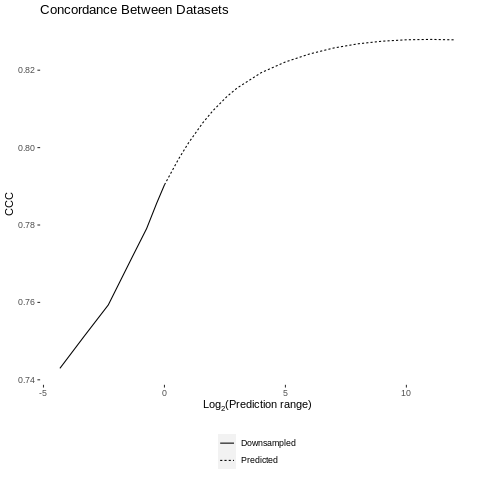

In [10]:
###########################################
#Fig A
###########################################
%%R
library(ggplot2)
#The plot has 2 curves, both just 10x prediction and prediction of both datasets
dsLen = length(dsGrade)
predLen = length(predVals)
numPoints = dsLen + predLen
corsBothPred = rep(0,numPoints)
for (i in 1:numPoints) {
  corsBothPred[i] = getCCC(mergedTot[[i+1]], mergedTot[[i+numPoints+1]])
}

#now create the plot with 2 curves, both double prediction and just 10x prediction
pred = factor(c(rep(0,dsLen),rep(1, length(predVals))), c(0,1), c("Downsampled", "Predicted"))
x = xes
y = corsBothPred

df = data.frame(x=x, y=y, pred = pred)

fig4D = ggplot(df, aes(x=x, y=y, group=pred, linetype=pred)) + 
  geom_line() + #geom_point(size=1.5) +
  labs(y="CCC", x=expression(Log[2]*"(Prediction range)")) +
  ggtitle("Concordance Between Datasets") +
  theme(panel.background = element_rect("white", "white", 0, 0, "white"), legend.position= "bottom", 
        legend.direction = "vertical", legend.box = "horizontal", legend.title = element_blank()) +
  guides(fill=guide_legend(nrow=2, ncol=1, byrow=F))

print(fig4D)

#save them individually since we want different heights, so the x axis labels of both plots are at the same y coord:
ggsave(
  paste0(figure_path, "Fig4D.png"),
  plot = fig4D, device = "png",
  width = 3.65, height = 4.3, dpi = 300)


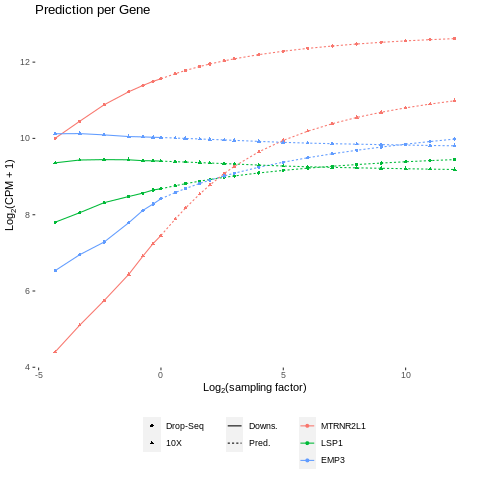

In [11]:
###########################################
#Fig 4E
###########################################
%%R

g1 = "MTRNR2L1"
g2 = "LSP1"
g3 = "EMP3"

gene1 = as.numeric(mergedTot[mergedTot$gene == g1, -1])
gene2 = as.numeric(mergedTot[mergedTot$gene == g2, -1])
gene3 = as.numeric(mergedTot[mergedTot$gene == g3, -1])

genes = c(gene1,gene2,gene3)
geneNames = c(g1,g2,g3)

#create data frame for plot:
y = genes
x = rep(xes,2*length(geneNames))
pred = rep(factor(c(rep(0,dsLen),rep(1, length(predVals))), c(0,1), c("Downs.", "Pred.")),2*length(geneNames))
gene = rep(0:(length(geneNames)-1), each=length(xes)*2)
genef = factor(gene, 0:(length(geneNames)-1), geneNames)
technology = factor(rep(c(rep(0,numPoints), rep(1,numPoints)),length(geneNames)), c(0,1), c("Drop-Seq", "10X"))

df = data.frame(x=x, y=y, dspred = pred, Gene = genef, Technology = technology, stringsAsFactors = F)

fig4E = ggplot(df, aes(x=x, y=y, colour = Gene, linetype=dspred, shape=Technology, group=interaction(Gene,dspred, Technology))) + 
  geom_line() + geom_point(size=1.2) +
  ggtitle("Prediction per Gene") +
  xlab(expression(Log[2]*"(sampling factor)")) + ylab(expression(Log[2]*"(CPM + 1)")) +
  theme(panel.background = element_rect("white", "white", 0, 0, "white"),
        legend.position= "bottom", legend.direction = "vertical", legend.box = "horizontal", legend.title = element_blank(),
        strip.background = element_blank()) +
  guides(fill=guide_legend(nrow=2, ncol=1, byrow=F))
print(fig4E)


ggsave(
  paste0(figure_path, "Fig4E.png"),
  plot = fig4E, device = "png",
  width = 3.65, height = 4.545, dpi = 300)

